In [1]:
# !git clone https://github.com/vincentnam/ProjetInterpromo2020G8.git

In [2]:
from layout_processing.blackwhite import BlackWhite
from layout_processing.colourpipelinezone import ColourPipelineZones
from layout_processing.pipeline import Pipeline
from layout_processing.removedoubleseat import RemoveDoubleSeat
from layout_processing.seatfinder import SeatFinder
from layout_processing.segmentationzone import SegmentationZone

In [3]:
base_data_path = "/data/dataset/projetinterpromo/Interpromo2020/"

# Pipeline Seat

In [4]:
pipeline_seat = Pipeline(base_data_path,["Aer_Lingus_Airbus_A330-300_A_plane6.jpg"])
pipeline_seat.add_processes([BlackWhite, SeatFinder, RemoveDoubleSeat])

OpenCV4.1.2.30 -> rgb to grey a été ajouté.
OpenCV4.1.2.30 -> Pattern Matching seat a été ajouté.
Standard Python >= 3.5 -> remove double point in list a été ajouté.


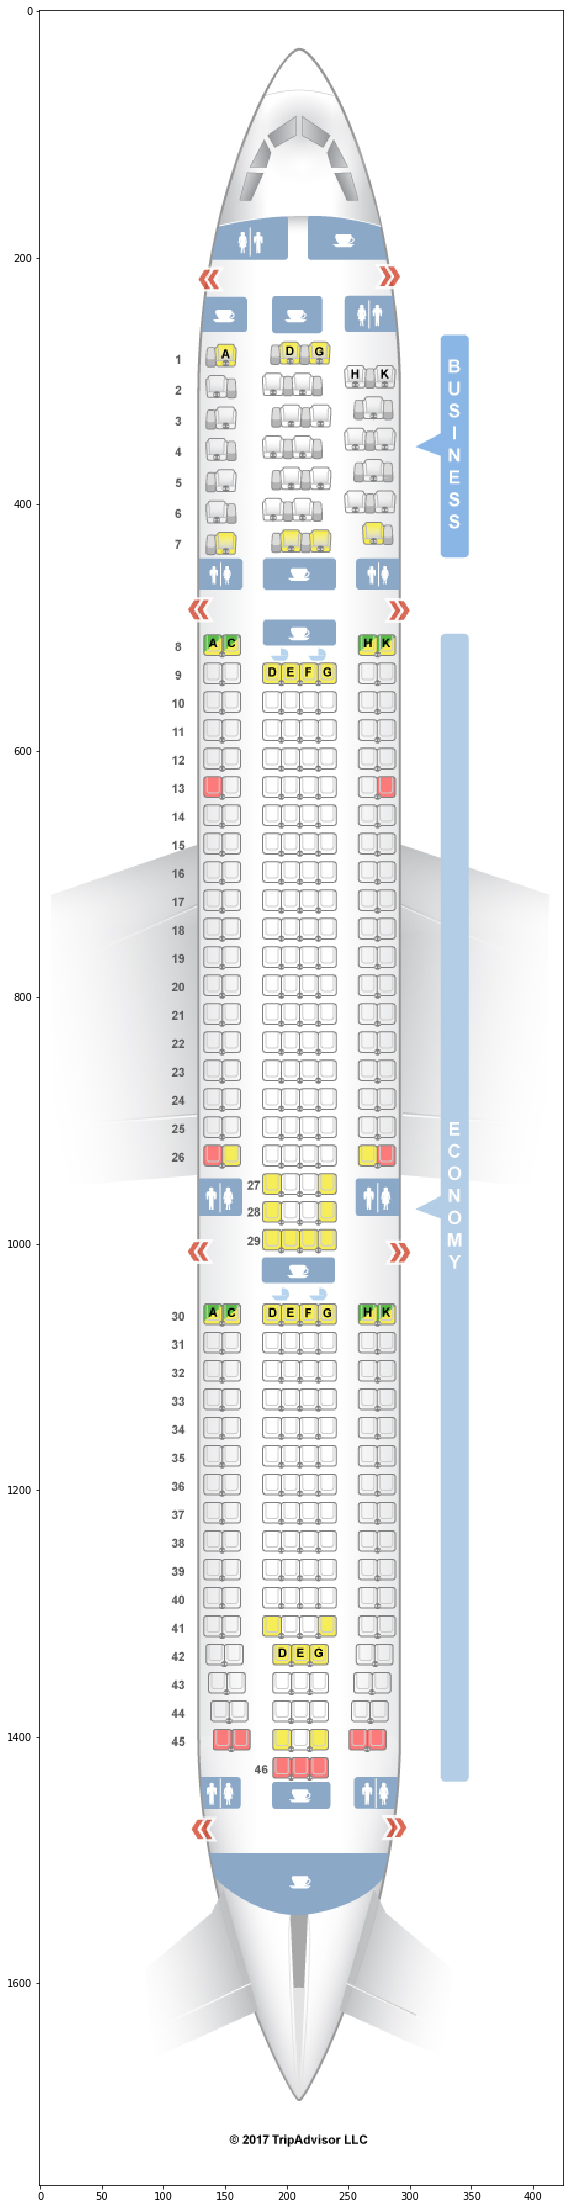

Pipeline start : 
Preprocess :  OpenCV4.1.2.30 -> rgb to grey
Doing : OpenCV4.1.2.30 -> rgb to grey


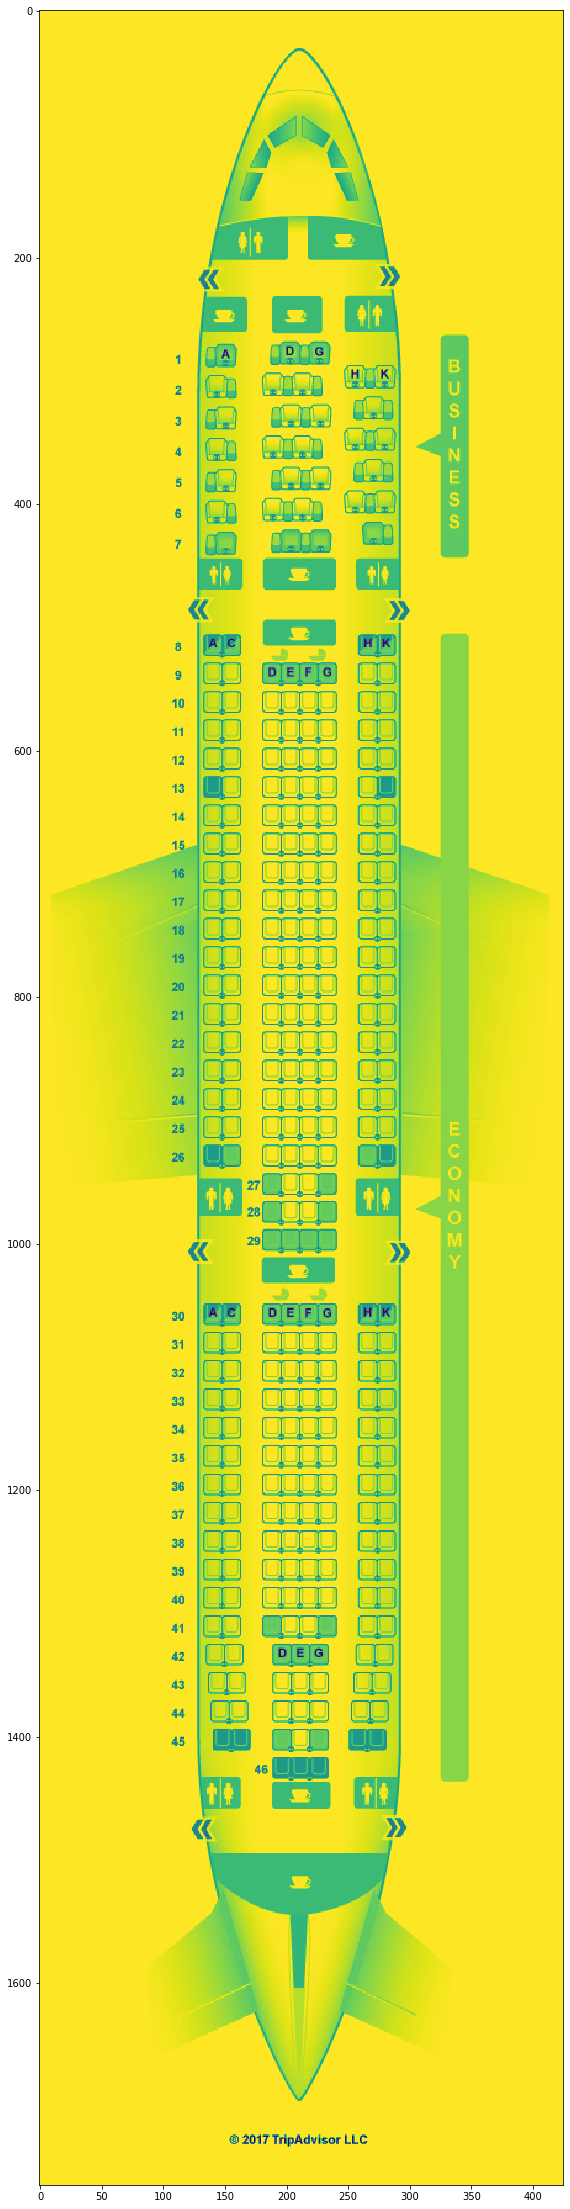

Process :  OpenCV4.1.2.30 -> Pattern Matching seat
Doing : OpenCV4.1.2.30 -> Pattern Matching seat
{'Aer_Lingus_Airbus_A330-300_A_plane6.jpg': {'BUSINESS': [(181, 294, 20, 18), (205, 294, 20, 18), (181, 345, 20, 18), (205, 345, 20, 18), (135, 296, 20, 18), (262, 313, 20, 18), (135, 347, 20, 18), (181, 396, 20, 18), (262, 364, 20, 18), (219, 370, 20, 18), (205, 396, 20, 18), (142, 372, 20, 18), (248, 389, 20, 18), (135, 398, 20, 18), (195, 370, 20, 18), (271, 389, 20, 18), (142, 321, 20, 18), (196, 370, 20, 18), (135, 397, 20, 18), (181, 395, 20, 18), (263, 313, 20, 18), (143, 372, 20, 18), (248, 339, 20, 18), (247, 389, 20, 18), (219, 319, 20, 18), (219, 320, 20, 18), (205, 395, 20, 18), (263, 364, 20, 18), (271, 339, 20, 18), (262, 415, 20, 18), (219, 421, 20, 18), (143, 321, 20, 18), (248, 338, 20, 18), (205, 345, 20, 18), (205, 396, 20, 18), (205, 294, 20, 18), (181, 345, 20, 18), (181, 294, 20, 18), (181, 396, 20, 18), (248, 339, 20, 18), (135, 296, 20, 18), (196, 320, 20, 18), (13

In [5]:
pipeline_seat.run_pipeline(1, verbose = 2)

# Pipeline Zone

Standard Python >= 3.5 -> preprocess colours a été ajouté.
OpenCV4.1.2.30 -> rgb to grey a été ajouté.
OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas a été ajouté.


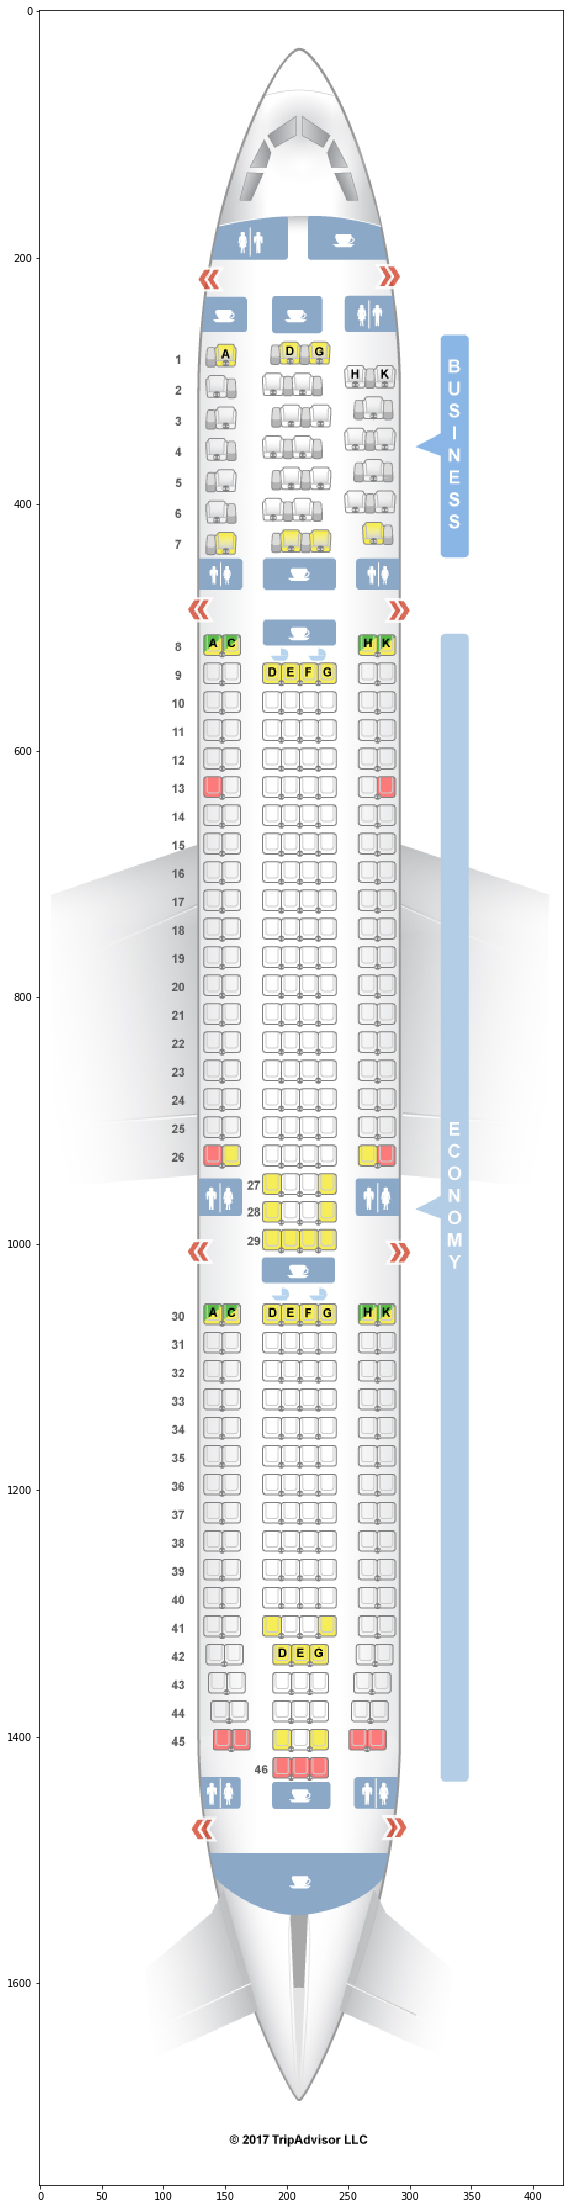

Pipeline start : 
Preprocess :  Standard Python >= 3.5 -> preprocess colours
Doing : Standard Python >= 3.5 -> preprocess colours


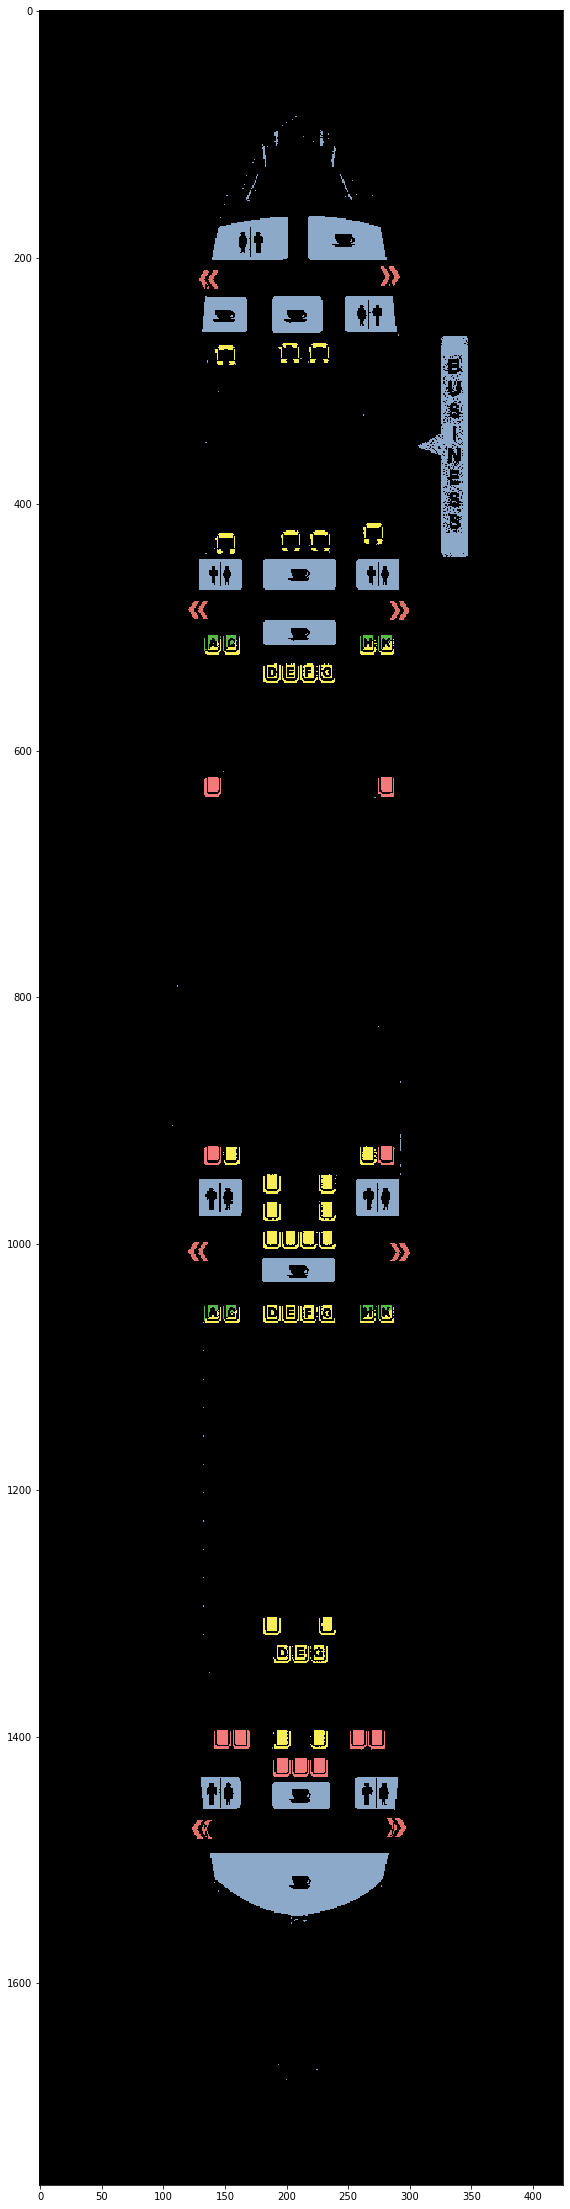

Preprocess :  OpenCV4.1.2.30 -> rgb to grey
Doing : OpenCV4.1.2.30 -> rgb to grey


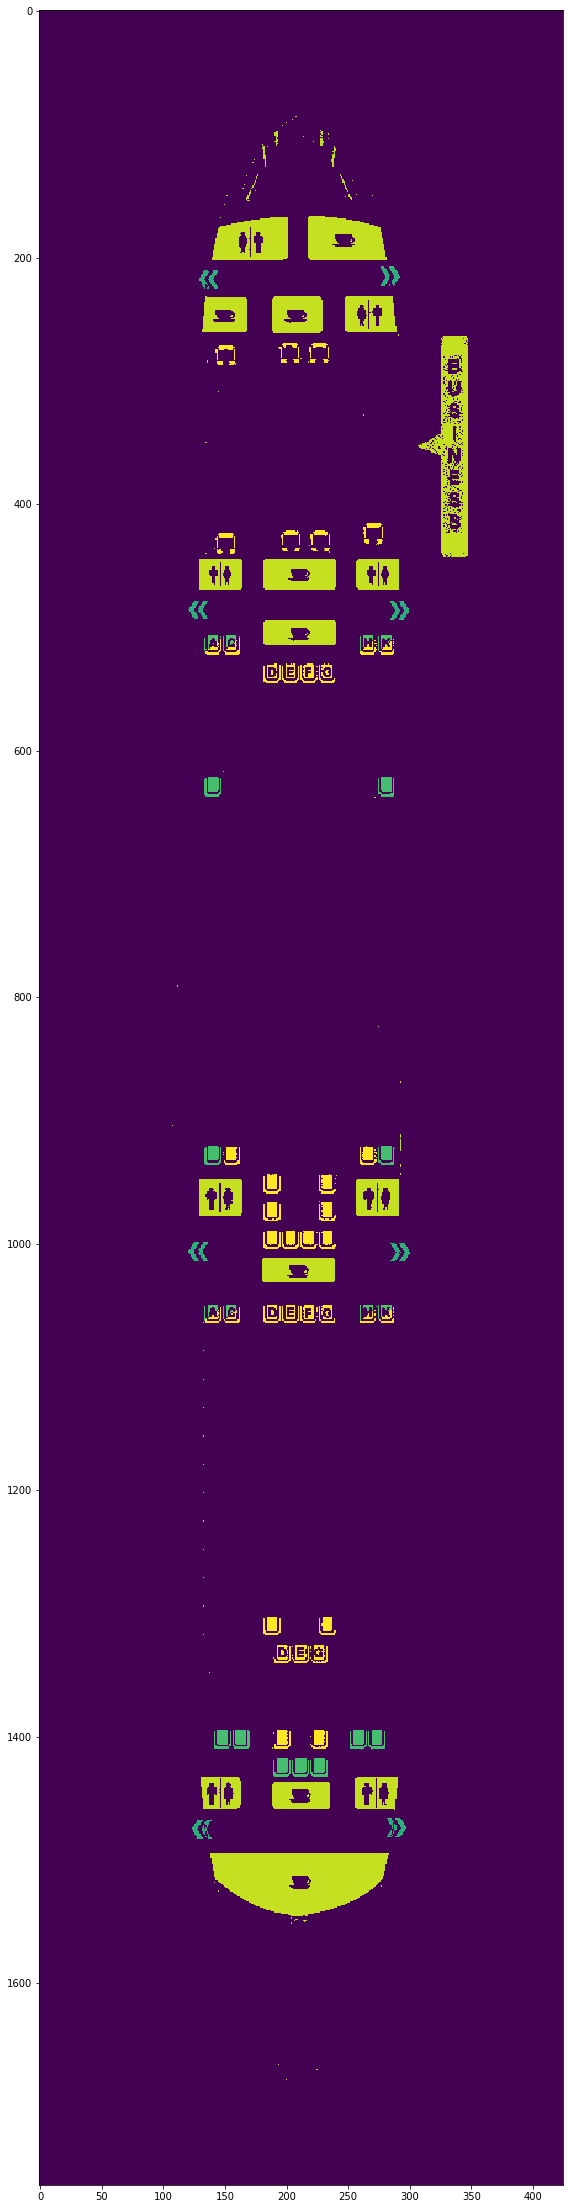

Process :  OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas
Doing : OpenCV4.1.2.30 / Scikit-image 0.16-> segmentation over colour areas


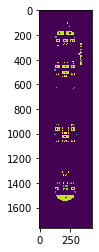

['bar4.png', 'bar5.png', 'sortie_droit.png', 'sortie_droit3.png', 'sortie_droit4.png', 'sortie_droit6.png', 'sortie_droit7.png', 'sortie_droit8.png', 'sortie_droit9.png', 'sortie_gauche.png', 'sortie_gauche2.png', 'sortie_gauche3.png', 'sortie_gauche4.png', 'toilettes.png', 'toilettes2.png', 'toilettes3.png', 'toilettes4.png', 'toilettes5.png', 'toilettes6.png', 'toilettes7.png']


In [6]:
pipeline_zone = Pipeline(base_data_path,["Aer_Lingus_Airbus_A330-300_A_plane6.jpg"])
pipeline_zone.add_processes([ColourPipelineZones, BlackWhite, SegmentationZone])
pipeline_zone.run_pipeline(1)

dict_keys(['Aer_Lingus_Airbus_A330-300_A_plane6.jpg'])
dict_keys(['Aer_Lingus_Airbus_A330-300_A_plane6.jpg'])


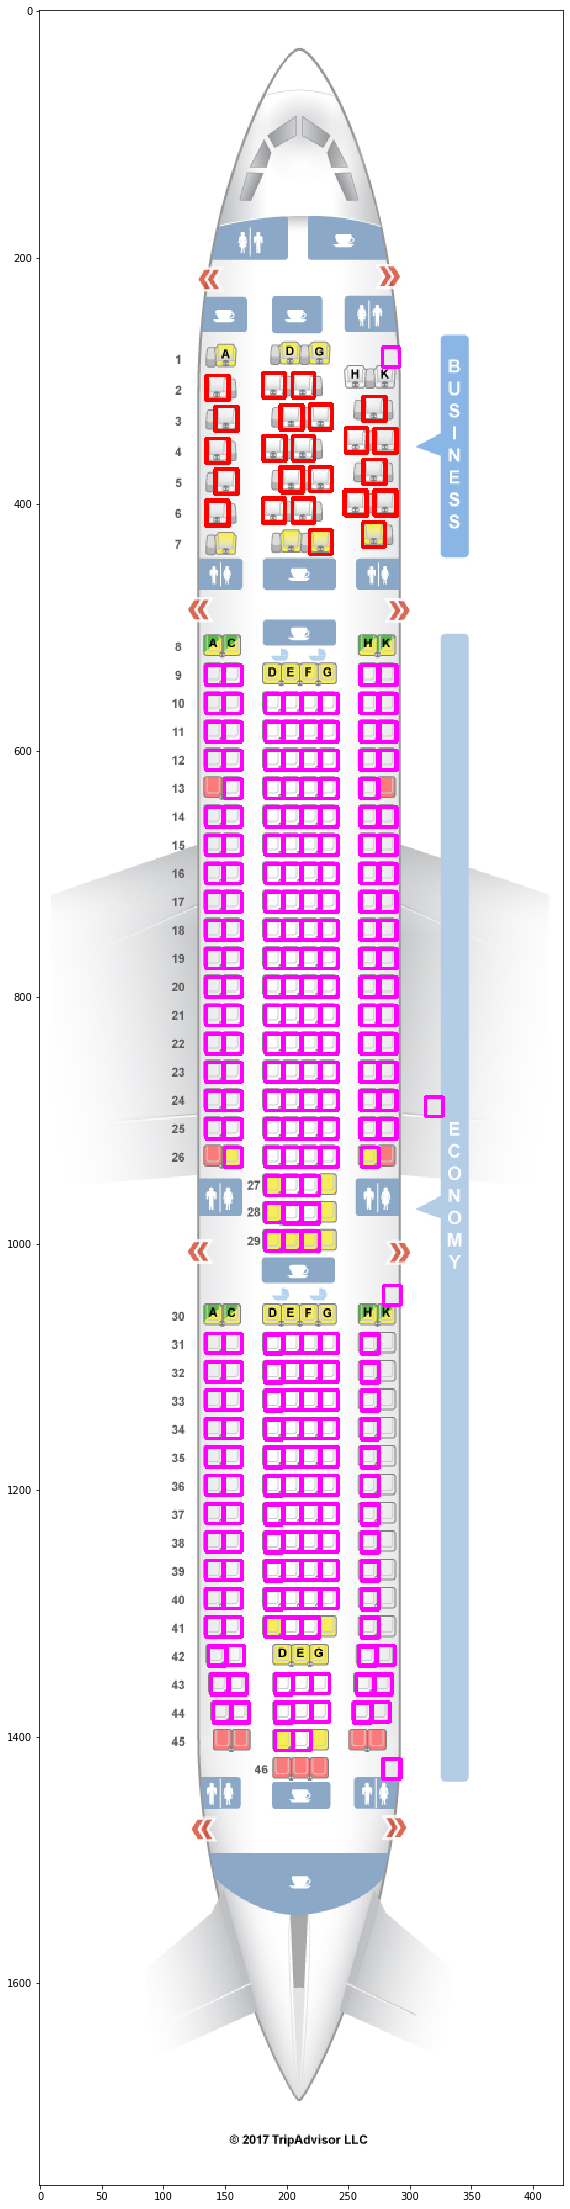

In [11]:
import cv2 as cv 
import matplotlib.pyplot as plt 

print(pipeline_zone.json.keys())
print(pipeline_.json.keys())

def to_rgb(image):
        return cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
def draw_contour(image, name_img, pipeline_zone, pipeline_seat, type = 2):
    
    image = to_rgb(image) # change color postion BGR to RGB
    
    # 
    dict_colour_seat = {'BUSINESS': (255, 0, 0),
                     'ECONOMY': (255, 0, 255),
                     'FIRST': (0, 255, 0),
                     'PREMIUM': (255, 255, 0)}
    
    # for each rectangles it will draw it on the image
    if type ==2 or if type== 1 : 
        for zone in pipeline_zone[name_img]:
            for rect in pipeline_zone[name_img][zone]:
                y, x = rect[0], rect[1]
                w, h = abs(x-rect[3]), abs(y-rect[2])
                image = cv.rectangle(image, (x,y), (x+w, y+h),(0,0,255), 2)
    if type == 2 or if type == 0 : 
        for category in pipeline_seat[name_img]:
            for seat in pipeline_seat[name_img][category]:
                x , y = seat[0], seat[1]
                h, w = seat[2], seat[3]
                image = cv.rectangle(image, (x,y), (x+w, y+h),dict_colour_seat[category], 2)
     
    plt.figure(figsize=(20,40))
    plt.imshow(image)

image = cv.imread(base_data_path + '/All Data'+
                 '/ANALYSE IMAGE/LAYOUT SEATGURU/Aer_Lingus_Airbus_A330-300_A_plane6.jpg')

draw_contour(image,"Aer_Lingus_Airbus_A330-300_A_plane6.jpg", pipeline_zone.json, pipeline_seat.json)

## Pipeline Merge

In [8]:
from layout_processing.distpipeline import DistPipeline

In [9]:
dist_pipeline = DistPipeline(pipeline_seat, pipeline_zone)

In [10]:
json_dist = dist_pipeline.to_json_simple_distance(dist_pipeline.pipeline.json, dist_pipeline.pipeline_zone.json)

#print(json_dist)